<a href="https://colab.research.google.com/github/ahmadizza/Convolutional-Neural-Network-CNN-for-CIFAR-10-Classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projek UTS Deep Learning**

## **Kelompok 2:**
*   Ahmad Izza - 11220940000006
*   Ahmad Fauzan - 11220940000031

## **Bagian CNN**


*Untuk resnet ada di notebook terpisah:*
*   Link resnet: https://colab.research.google.com/drive/1bv6l7a2KCs5JNzuiWEYvFSIH8nl-GyuS?usp=sharing
*   Link PPT: https://drive.google.com/file/d/1cRo_Glp3IvqBF6KJeJ1USvVSaJbiFVMz/view?usp=sharing


### **Konfigurasi Awal: Random Seed dan Device**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [ ]:
# Set global seed for reproducibility
def set_seed(seed_value):
    """
    Mengatur seed untuk reproducibility di Python, NumPy, dan PyTorch.
    """
    random.seed(seed_value) # Mengatur seed untuk random number generator Python
    np.random.seed(seed_value) # Mengatur seed untuk random number generator NumPy
    torch.manual_seed(seed_value) # Mengatur seed untuk random number generator PyTorch di CPU
    if torch.cuda.is_available(): # Memeriksa ketersediaan GPU
        torch.cuda.manual_seed(seed_value) # Mengatur seed untuk random number generator PyTorch di GPU (single GPU)
        torch.cuda.manual_seed_all(seed_value) # Mengatur seed untuk semua GPU jika tersedia
        torch.backends.cudnn.deterministic = True # Memastikan operasi CUDA deterministik untuk reproducibility
        torch.backends.cudnn.benchmark = False  # Menonaktifkan auto-tuner CuDNN
    os.environ['PYTHONHASHSEED'] = str(seed_value) # Mengatur seed untuk hash Python agar konsisten

set_seed(42)  # Angka seed yang umum digunakan

# Tentukan penggunaan GPU jika tersedia, jika tidak, gunakan CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda:0


### **Persiapan Data**

In [ ]:
transform_train = transforms.Compose([  # Transformasi untuk data pelatihan dengan augmentasi
    transforms.RandomCrop(32, padding=4),  # Memotong gambar secara acak ke 32x32 dengan padding 4
    transforms.RandomHorizontalFlip(),  # Membalik gambar secara horizontal secara acak
    transforms.ToTensor(),  # Mengubah gambar ke tensor PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Menormalkan nilai piksel ke [-1, 1]
])

transform_eval = transforms.Compose([  # Transformasi untuk data evaluasi tanpa augmentasi
    transforms.ToTensor(),  # Mengubah gambar ke tensor PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Menormalkan nilai piksel ke [-1, 1]
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)  # Memuat dataset pelatihan CIFAR-10 dengan transformasi pelatihan
full_valset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_eval)  # Memuat dataset pelatihan CIFAR-10 untuk validasi dengan transformasi evaluasi
val_size = int(0.1 * len(full_trainset))  # Menentukan ukuran set validasi (10% dari data pelatihan)
train_size = len(full_trainset) - val_size  # Menentukan ukuran set pelatihan (90% dari data pelatihan)
train_indices, val_indices = random_split(range(len(full_trainset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))  # Membagi indeks untuk pelatihan dan validasi dengan seed 42
trainset = torch.utils.data.Subset(full_trainset, train_indices)  # Membuat subset pelatihan berdasarkan indeks
valset = torch.utils.data.Subset(full_valset_raw, val_indices)  # Membuat subset validasi berdasarkan indeks
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_eval)  # Memuat dataset pengujian CIFAR-10 dengan transformasi evaluasi

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # Daftar nama kelas CIFAR-10

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


**Transformasi Data:**

*  `transform_train` mencakup augmentasi
(random crop dan horizontal flip) untuk meningkatkan variasi data pelatihan, diikuti dengan konversi ke tensor dan normalisasi ke rentang [-1, 1].
*   `transform_eval` hanya mencakup konversi ke tensor dan normalisasi tanpa augmentasi untuk data validasi dan pengujian.

**Informasi Data:**
*   Jumlah data untuk pelatihan (45.000), validasi (5.000), dan pengujian (10.000) dicetak untuk memverifikasi pembagian, dengan total 60.000 gambar sesuai dataset CIFAR-10.






### **Define Model CNN**

In [ ]:
class CustomCNN(nn.Module):  # Definisi arsitektur CustomCNN sebagai turunan dari nn.Module
    def __init__(self):  # Inisialisasi model dengan lapisan konvolusi, pooling, fully connected, dan normalisasi
        super(CustomCNN, self).__init__()  # Memanggil konstruktor kelas induk nn.Module
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # Lapisan konvolusi pertama: input 3 channel (RGB), output 64 filter, kernel 3x3, padding 1
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # Lapisan konvolusi kedua: input 64 channel, output 128 filter, kernel 3x3, padding 1
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # Lapisan konvolusi ketiga: input 128 channel, output 256 filter, kernel 3x3, padding 1
        self.pool = nn.MaxPool2d(2, 2)  # Lapisan max pooling: kernel 2x2, stride 2
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # Lapisan fully connected pertama: input 256*4*4, output 1024 neuron
        self.fc2 = nn.Linear(1024, 10)  # Lapisan fully connected kedua: input 1024 neuron, output 10 kelas (CIFAR-10)
        self.dropout = nn.Dropout(0.4)  # Lapisan dropout dengan probabilitas 0.4 untuk mencegah overfitting
        self.batchnorm1 = nn.BatchNorm2d(64)  # Batch normalization untuk lapisan konvolusi pertama (64 channel)
        self.batchnorm2 = nn.BatchNorm2d(128)  # Batch normalization untuk lapisan konvolusi kedua (128 channel)
        self.batchnorm3 = nn.BatchNorm2d(256)  # Batch normalization untuk lapisan konvolusi ketiga (256 channel)

    def forward(self, x):  # Definisi alur data melalui jaringan (forward pass)
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))  # Konvolusi 1 -> BatchNorm -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Konvolusi 2 -> BatchNorm -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))  # Konvolusi 3 -> BatchNorm -> ReLU -> MaxPooling
        x = x.view(-1, 256 * 4 * 4)  # Meratakan output untuk input ke lapisan fully connected
        x = self.dropout(F.relu(self.fc1(x)))  # Fully connected 1 -> ReLU -> Dropout
        x = self.fc2(x)  # Fully connected 2 (output logits untuk 10 kelas)
        return x  # Mengembalikan output jaringan

*  Tiga lapisan konvolusi (`conv1, conv2, conv3`) dengan filter bertambah dari 64, 128, hingga 256, masing-masing dengan kernel 3x3 dan padding 1.
*   Lapisan max pooling (`pool`) dengan kernel 2x2 untuk mengurangi dimensi spasial.
*   Tiga lapisan batch normalization (`batchnorm1, batchnorm2, batchnorm3`) untuk menstabilkan pelatihan.
*   Dua lapisan fully connected (`fc1` dan `fc2`) dengan dropout (0.4) untuk mencegah overfitting





## **Fungsi Pelatihan dan Evaluasi**

In [ ]:
def train_and_evaluate(model, trainloader, valloader, testloader, criterion, optimizer, epochs, patience, evaluate_test=False):  # Fungsi untuk melatih dan mengevaluasi model
    set_seed(42)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)  # Inisialisasi scheduler untuk mengurangi learning rate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Inisialisasi list untuk menyimpan metrik pelatihan dan validasi
    best_val_acc = 0.0  # Inisialisasi akurasi validasi terbaik
    best_model_wts = None  # Inisialisasi bobot model terbaik
    epochs_no_improve = 0  # Penghitung epoch tanpa peningkatan akurasi validasi

    for epoch in range(epochs):  # Iterasi untuk setiap epoch
        model.train()  # Mengatur model ke mode pelatihan
        running_loss, correct, total = 0.0, 0, 0  # Inisialisasi metrik pelatihan per epoch
        for inputs, labels in trainloader:  # Iterasi untuk setiap batch di trainloader
            inputs, labels = inputs.to(device), labels.to(device)  # Memindahkan data ke perangkat (GPU/CPU)
            optimizer.zero_grad()  # Mengatur gradien ke nol
            outputs = model(inputs)  # Menghitung output model
            loss = criterion(outputs, labels)  # Menghitung loss
            loss.backward()  # Menghitung gradien
            optimizer.step()  # Memperbarui bobot model
            running_loss += loss.item()  # Menambahkan loss batch ke total
            _, predicted = torch.max(outputs, 1)  # Mendapatkan prediksi kelas
            total += labels.size(0)  # Menambahkan jumlah sampel
            correct += (predicted == labels).sum().item()  # Menambahkan jumlah prediksi benar
        train_loss = running_loss / len(trainloader)  # Menghitung rata-rata loss pelatihan
        train_acc = 100 * correct / total  # Menghitung akurasi pelatihan
        train_losses.append(train_loss)  # Menyimpan loss pelatihan
        train_accs.append(train_acc)  # Menyimpan akurasi pelatihan

        model.eval()  # Mengatur model ke mode evaluasi
        val_loss, correct, total = 0.0, 0, 0  # Inisialisasi metrik validasi
        with torch.no_grad():  # Menonaktifkan perhitungan gradien untuk evaluasi
            for inputs, labels in valloader:  # Iterasi untuk setiap batch di valloader
                inputs, labels = inputs.to(device), labels.to(device)  # Memindahkan data ke perangkat
                outputs = model(inputs)  # Menghitung output model
                loss = criterion(outputs, labels)  # Menghitung loss validasi
                val_loss += loss.item()  # Menambahkan loss batch ke total
                _, predicted = torch.max(outputs, 1)  # Mendapatkan prediksi kelas
                total += labels.size(0)  # Menambahkan jumlah sampel
                correct += (predicted == labels).sum().item()  # Menambahkan jumlah prediksi benar
        val_loss = val_loss / len(valloader)  # Menghitung rata-rata loss validasi
        val_acc = 100 * correct / total  # Menghitung akurasi validasi
        val_losses.append(val_loss)  # Menyimpan loss validasi
        val_accs.append(val_acc)  # Menyimpan akurasi validasi

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%')  # Mencetak metrik per epoch

        if val_acc > best_val_acc:  # Memeriksa apakah akurasi validasi meningkat
            best_val_acc = val_acc  # Memperbarui akurasi validasi terbaik
            best_model_wts = model.state_dict()  # Menyimpan bobot model terbaik
            torch.save(best_model_wts, 'best_model.pth')  # Menyimpan model ke file
            print(f'Saved best model with Val Acc: {best_val_acc:.2f}%')  # Mencetak konfirmasi penyimpanan
            epochs_no_improve = 0  # Mengatur ulang penghitung early stopping
        else:
            epochs_no_improve += 1  # Menambah penghitung jika tidak ada peningkatan

        scheduler.step(val_acc)  # Memperbarui learning rate berdasarkan akurasi validasi
        if epochs_no_improve >= patience:  # Memeriksa kondisi early stopping
            print(f'Early stopping at epoch {epoch+1}')  # Mencetak pemberitahuan early stopping
            break  # Menghentikan pelatihan

    if best_model_wts is not None:  # Memeriksa apakah ada bobot terbaik
        model.load_state_dict(best_model_wts)  # Memuat bobot terbaik ke model

    if evaluate_test:  # Memeriksa apakah evaluasi pada test set diperlukan
        model.eval()  # Mengatur model ke mode evaluasi
        test_preds, test_labels = [], []  # Inisialisasi list untuk prediksi dan label
        with torch.no_grad():  # Menonaktifkan perhitungan gradien
            for inputs, labels in testloader:  # Iterasi untuk setiap batch di testloader
                inputs, labels = inputs.to(device), labels.to(device)  # Memindahkan data ke perangkat
                outputs = model(inputs)  # Menghitung output model
                _, predicted = torch.max(outputs, 1)  # Mendapatkan prediksi kelas
                test_preds.extend(predicted.cpu().numpy())  # Menyimpan prediksi
                test_labels.extend(labels.cpu().numpy())  # Menyimpan label asli
        test_acc = 100 * sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)  # Menghitung akurasi pengujian
        print(f'Test Accuracy: {test_acc:.2f}%')  # Mencetak akurasi pengujian
        return train_losses, val_losses, train_accs, val_accs, test_preds, test_labels, best_val_acc  # Mengembalikan metrik dan hasil pengujian

    return train_losses, val_losses, train_accs, val_accs, best_val_acc  # Mengembalikan metrik tanpa hasil pengujian


*   Pelatihan model dengan optimizer Adam dan scheduler `ReduceLROnPlateau` untuk menyesuaikan learning rate berdasarkan akurasi validasi.
*   Early stopping dengan `patience=15` untuk menghentikan pelatihan jika tidak ada peningkatan setelah 15 epoch.



## **Hyperparameter tuning**



*   Hyperparameter diuji dengan kombinasi `learning_rates = [0.001, 0.003]` dan `batch_sizes = [32, 64, 128]`.
*   Untuk setiap kombinasi, model dilatih menggunakan `train_and_evaluate` dengan 30 epoch dan tanpa evaluasi test set pada tahap tuning.



In [ ]:
learning_rates = [0.001, 0.003]  # Daftar learning rate untuk tuning
batch_sizes = [32, 64, 128]  # Daftar ukuran batch untuk tuning
best_val_acc = 0  # Inisialisasi akurasi validasi terbaik
best_params = {}  # Inisialisasi dictionary untuk parameter terbaik
best_model = None  # Inisialisasi model terbaik

for lr in learning_rates:  # Iterasi untuk setiap learning rate
    for bs in batch_sizes:  # Iterasi untuk setiap ukuran batch
        print(f'\nTuning: lr={lr}, batch_size={bs}')  # Mencetak kombinasi hiperparameter
        trainloader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0, generator=torch.Generator().manual_seed(42))  # Membuat DataLoader untuk pelatihan
        valloader = DataLoader(valset, batch_size=bs, shuffle=False, num_workers=0, generator=torch.Generator().manual_seed(42))  # Membuat DataLoader untuk validasi
        testloader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0, generator=torch.Generator().manual_seed(42))  # Membuat DataLoader untuk pengujian
        model = CustomCNN().to(device)  # Inisialisasi model CustomCNN
        criterion = nn.CrossEntropyLoss()  # Inisialisasi fungsi loss
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Inisialisasi optimizer Adam
        train_losses, val_losses, train_accs, val_accs, curr_best_val_acc = train_and_evaluate(  # Melatih dan mengevaluasi model
            model, trainloader, valloader, testloader, criterion, optimizer,  # Parameter fungsi
            epochs=30, patience=15, evaluate_test=False  # Pengaturan pelatihan
        )
        if curr_best_val_acc > best_val_acc:  # Memeriksa akurasi validasi terbaik
            best_val_acc = curr_best_val_acc  # Memperbarui akurasi validasi terbaik
            best_params = {'lr': lr, 'batch_size': bs}  # Memperbarui parameter terbaik
            best_model = model  # Memperbarui model terbaik
            best_train_losses, best_val_losses, best_train_accs, best_val_accs = train_losses, val_losses, train_accs, val_accs  # Menyimpan metrik terbaik

print(f'\nBest Hyperparameters: {best_params}')  # Mencetak hiperparameter terbaik


Tuning: lr=0.001, batch_size=32


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 1.581, Train Acc: 42.56%, Val Loss: 1.134, Val Acc: 59.64%
Saved best model with Val Acc: 59.64%
Epoch 2/30 - Train Loss: 1.213, Train Acc: 56.68%, Val Loss: 0.981, Val Acc: 65.30%
Saved best model with Val Acc: 65.30%
Epoch 3/30 - Train Loss: 1.050, Train Acc: 63.20%, Val Loss: 0.794, Val Acc: 71.64%
Saved best model with Val Acc: 71.64%
Epoch 4/30 - Train Loss: 0.943, Train Acc: 66.98%, Val Loss: 0.745, Val Acc: 73.56%
Saved best model with Val Acc: 73.56%
Epoch 5/30 - Train Loss: 0.869, Train Acc: 69.94%, Val Loss: 0.736, Val Acc: 73.94%
Saved best model with Val Acc: 73.94%
Epoch 6/30 - Train Loss: 0.798, Train Acc: 72.68%, Val Loss: 0.630, Val Acc: 77.54%
Saved best model with Val Acc: 77.54%
Epoch 7/30 - Train Loss: 0.749, Train Acc: 74.57%, Val Loss: 0.597, Val Acc: 78.50%
Saved best model with Val Acc: 78.50%
Epoch 8/30 - Train Loss: 0.699, Train Acc: 76.03%, Val Loss: 0.568, Val Acc: 80.40%
Saved best model with Val Acc: 80.40%
Epoch 9/30 - Train Loss:

## **Evaluasi Best Model pada Data Set**

In [ ]:
print('\nEvaluating best model on test set:')  # Mencetak pesan evaluasi test set
trainloader = DataLoader(trainset, batch_size=best_params['batch_size'], shuffle=True)  # Membuat DataLoader untuk pelatihan
valloader = DataLoader(valset, batch_size=best_params['batch_size'], shuffle=False)  # Membuat DataLoader untuk validasi
testloader = DataLoader(testset, batch_size=best_params['batch_size'], shuffle=False)  # Membuat DataLoader untuk pengujian
train_losses, val_losses, train_accs, val_accs, test_preds, test_labels, best_val_acc = train_and_evaluate(  # Mengevaluasi model terbaik
    best_model, trainloader, valloader, testloader, criterion, optimizer,  # Parameter fungsi
    epochs=1, patience=15, evaluate_test=True  # Pengaturan evaluasi
)


Evaluating best model on test set:
Epoch 1/1 - Train Loss: 0.298, Train Acc: 89.70%, Val Loss: 0.381, Val Acc: 86.84%
Saved best model with Val Acc: 86.84%
Test Accuracy: 87.25%


In [ ]:
# Simpan model terbaik ke file
torch.save(best_model.state_dict(), 'best_customcnn_model.pth')
print("Model terbaik telah disimpan sebagai 'best_customcnn_model.pth'")

Model terbaik telah disimpan sebagai 'best_customcnn_model.pth'


## **Plotting Loss dan Akurasi**

Plotting akan otomatis menggunakan `best_result` yang sudah diidentifikasi.

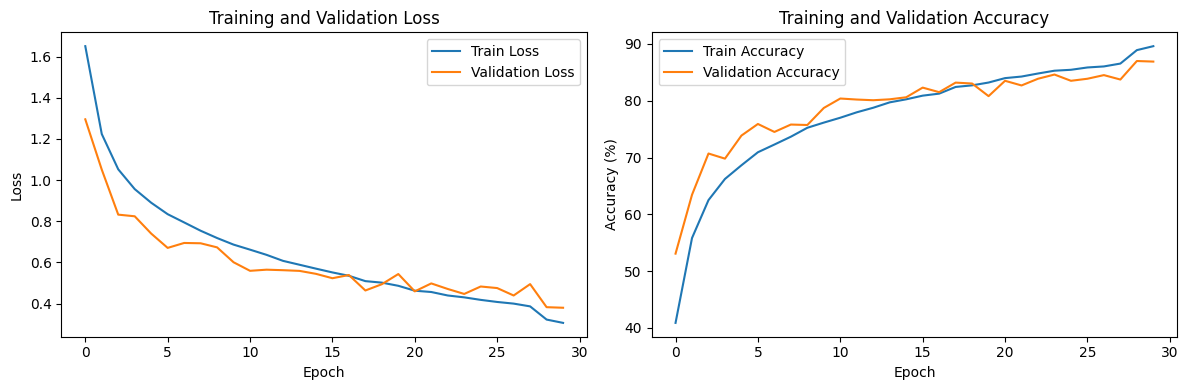

In [ ]:
# Training and Validation Loss & Accuracy Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_accs, label='Train Accuracy')
plt.plot(best_val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()

**Grafik Training and Validation Loss:**
*   **Train Loss** dan **Validation Loss** sama-sama menurun seiring bertambah epoch.
*   Menunjukkan bahwa model berhasil belajar dari data dan tidak mengalami overfitting.
*   Loss validasi sempat stagnan namun kembali menurun, yang berarti model tetap generalisasi dengan baik.
*   **Kesimpulan:**
Model menunjukkan performa pelatihan yang stabil dan efektif, dengan tren loss yang konsisten menurun.

**Grafik Training and Validation Accuracy:**

*   Akurasi pelatihan meningkat secara konsisten hingga mendekati 90%.
*   Akurasi validasi juga meningkat dan cenderung mendekati akurasi pelatihan, meskipun sedikit fluktuatif.
*   Tidak ada gap besar antara akurasi pelatihan dan validasi, yang menandakan model **tidak overfitting**
*   **Kesimpulan:**
Model memiliki kinerja yang baik, mampu mengklasifikasikan data dengan akurasi tinggi, dan generalisasi yang cukup baik terhadap data baru.








## **Confusion Matrix untuk Test Set**

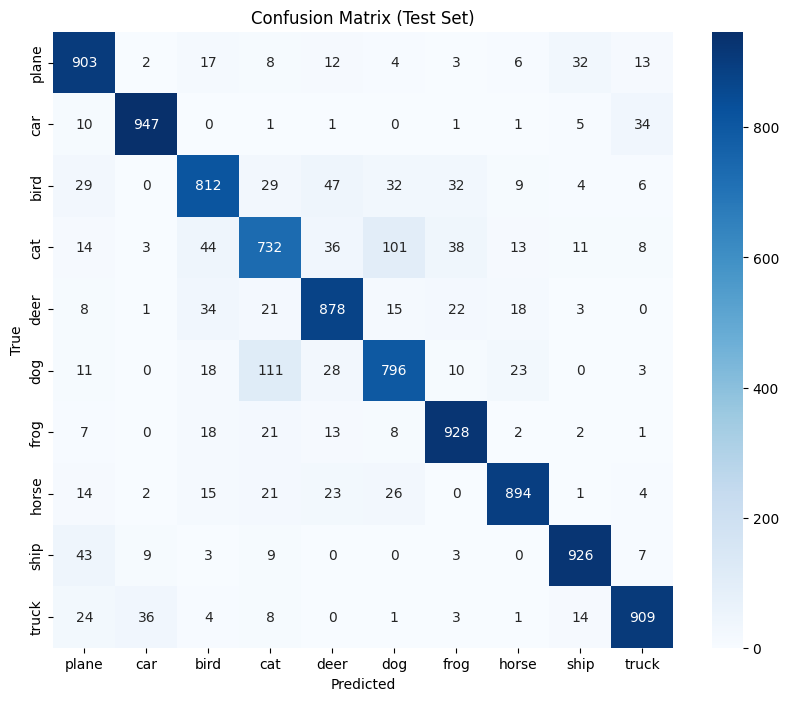

In [ ]:
# Confusion Matrix untuk Test Set
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

## **Precision, Recall, and F1-Score untuk Test Set**

In [ ]:
# Precision, Recall, and F1-Score for Test Set
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
try:
    from termcolor import colored
except ImportError:
    print("Library 'termcolor' tidak ditemukan. Instal dengan 'pip install termcolor' untuk warna.")
    colored = lambda x, *args, **kwargs: x  # Fallback jika termcolor tidak ada

# Metrik per kelas
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=None)
print("\n" + "="*60)
print(colored(" METRICS PER CLASS (TEST SET) ", "green", attrs=["bold", "underline"]))
print("="*60)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)
for i, class_name in enumerate(classes):
    print(f"{colored(class_name, 'cyan'):<15} {precision[i]:<12.3f} {recall[i]:<12.3f} {f1[i]:<12.3f}")
print("="*60)

# Metrik keseluruhan (macro-average dan weighted-average)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(colored("\n OVERALL METRICS (TEST SET) ", "green", attrs=["bold", "underline"]))
print("="*60)
print(f"{'Type':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)
print(f"{colored('Macro-Average', 'yellow'):<15} {precision_macro:<12.3f} {recall_macro:<12.3f} {f1_macro:<12.3f}")
print(f"{colored('Weighted-Average', 'yellow'):<15} {precision_weighted:<12.3f} {recall_weighted:<12.3f} {f1_weighted:<12.3f}")
print("="*60)


 METRICS PER CLASS (TEST SET) 
Class           Precision    Recall       F1-Score    
------------------------------------------------------------
plane           0.849        0.903        0.875       
car             0.947        0.947        0.947       
bird            0.841        0.812        0.826       
cat             0.762        0.732        0.747       
deer            0.846        0.878        0.862       
dog             0.810        0.796        0.803       
frog            0.892        0.928        0.910       
horse           0.925        0.894        0.909       
ship            0.928        0.926        0.927       
truck           0.923        0.909        0.916       

 OVERALL METRICS (TEST SET) 
Type            Precision    Recall       F1-Score    
------------------------------------------------------------
Macro-Average   0.872        0.873        0.872       
Weighted-Average 0.872        0.873        0.872       



**Secara Keseluruhan:**
*   **Macro Avg (87%):** Rata-rata metrik tanpa mempertimbangkan jumlah sampel per kelas. Digunakan untuk menilai keseimbangan performa model terhadap semua kelas secara adil.
*   **Weighted Avg (87%):** Rata-rata yang mempertimbangkan jumlah sampel di tiap kelas. Karena dataset CIFAR-10 seimbang, nilainya setara dengan macro average.
*   Macro-Average dan Weighted-Average F1-Score sama, yaitu 0.872, menunjukkan performa model konsisten di seluruh kelas tanpa bias ke kelas tertentu.


**Per Kelas:**
*   **Car:** Dengan precision dan recall sama-sama 0.95, model sangat konsisten dalam mengenali mobil.
F1-score 0.95 menandakan performa luar biasa.
Mobil memiliki ciri visual yang sangat jelas dan mudah dikenali oleh model.
*   **Plane:**
Model mencapai precision 0.85, artinya dari semua prediksi "plane", 85% adalah benar.
Dengan recall 0.90, model berhasil mendeteksi 90% dari seluruh gambar pesawat yang sebenarnya.
F1-score 0.88 menunjukkan keseimbangan yang sangat baik antara precision dan recall.
Model cukup andal dalam mengenali gambar pesawat.
*   **Bird:**
Precision 0.84 menunjukkan model cukup akurat dalam memprediksi gambar burung,
Namun recall 0.81 mengindikasikan masih ada gambar burung yang terlewat.
F1-score 0.83 menunjukkan performa yang cukup baik, meskipun masih ada ruang untuk perbaikan.
Burung mungkin tertukar dengan hewan kecil lain seperti "cat" atau "frog".
*   **Cat:**
Dengan precision 0.76 dan recall 0.73, model cukup sering salah mengklasifikasikan kucing atau melewatkannya.
F1-score 0.75 menjadi yang terendah di antara semua kelas.
Hal ini menunjukkan bahwa kucing sulit dibedakan dari hewan lain, terutama anjing.
*   **Deer:**
Model mencatat precision 0.85 dan recall 0.88, artinya performa cukup kuat.
F1-score 0.86 mengindikasikan model dapat mengenali rusa dengan cukup andal.
Fitur visual rusa tampaknya cukup unik di mata model.
*   **Dog:**
Precision 0.81 dan recall 0.80 menunjukkan model cukup baik mengenali anjing,
Namun tidak seakurat kelas lain.
F1-score 0.80 mengindikasikan performa stabil, tapi masih bisa ditingkatkan.
Kesamaan visual antara anjing dan kucing mungkin jadi penyebab utama.
*   **Frog:**
Dengan precision 0.89 dan recall 0.93, model tampil sangat solid di kelas "frog".
F1-score 0.91 menunjukkan keseimbangan yang sangat baik.
Ciri visual katak tampaknya mudah dikenali dan dibedakan oleh model.
*   **Horse:**
Model mencatat precision 0.93, recall 0.89, dan F1-score 0.91, menandakan performa sangat baik.
Model cukup konsisten dalam mengenali gambar kuda dan jarang salah klasifikasi.
*   Ship:
Dengan precision 0.93, recall 0.93, dan F1-score 0.93, model sangat kuat pada kelas ini.
Gambar kapal hampir selalu dikenali dengan benar, menunjukkan fitur visualnya mudah diidentifikasi.
*   **Truck:**
Precision 0.92, recall 0.91, dan F1-score 0.92 menandakan performa yang stabil dan andal.
Meskipun truk dan mobil bisa mirip, model mampu membedakan keduanya cukup baik.















## **Akurasi dari Hasil Pelatihan**

In [ ]:
# Tampilkan Akurasi dari Hasil Pelatihan
final_train_acc = best_train_accs[-1] if best_train_accs else 0
final_val_acc = best_val_acc
print('\nFinal Accuracies:')
print(f'Training Accuracy: {final_train_acc:.2f}%')
print(f'Validation Accuracy: {final_val_acc:.2f}%')
print(f'Test Accuracy: {100 * sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels):.2f}%')


Final Accuracies:
Training Accuracy: 89.59%
Validation Accuracy: 86.84%
Test Accuracy: 87.25%


**Training Accuracy (89.59%):**

Sebanyak 89.59% dari data pelatihan berhasil diklasifikasikan dengan benar oleh model. Ini menunjukkan bahwa model telah belajar cukup baik dari data pelatihan.

**Validation Accuracy (86.84%):**

Selama proses pelatihan, model mencapai akurasi 86.84% pada data validasi. Artinya, model dapat mengeneralisasi cukup baik ke data yang belum pernah dilihat sebelumnya.

**Test Accuracy (87.25%):**

Pada data uji akhir, model mencapai akurasi 87.25%. Ini menandakan performa yang stabil dan kuat, dengan kemampuan klasifikasi yang konsisten di luar data pelatihan.

**Kesimpulan:**

Perbedaan kecil antara training, validation, dan test accuracy menunjukkan model tidak mengalami overfitting secara signifikan.
Model memiliki kemampuan generalisasi yang baik untuk dataset CIFAR-10.


In [ ]:
# Per-Class Accuracy
print('\nPer-Class Accuracy (Test Set):')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
best_model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {classes[i]:<10s}: {accuracy:.2f}%')
    else:
        print(f'Accuracy of {classes[i]:<10s}: N/A (0 samples)')


Per-Class Accuracy (Test Set):
Accuracy of plane     : 90.30%
Accuracy of car       : 94.70%
Accuracy of bird      : 81.20%
Accuracy of cat       : 73.20%
Accuracy of deer      : 87.80%
Accuracy of dog       : 79.60%
Accuracy of frog      : 92.80%
Accuracy of horse     : 89.40%
Accuracy of ship      : 92.60%
Accuracy of truck     : 90.90%


## **Analisis Feature Maps**


Prediksi Benar:


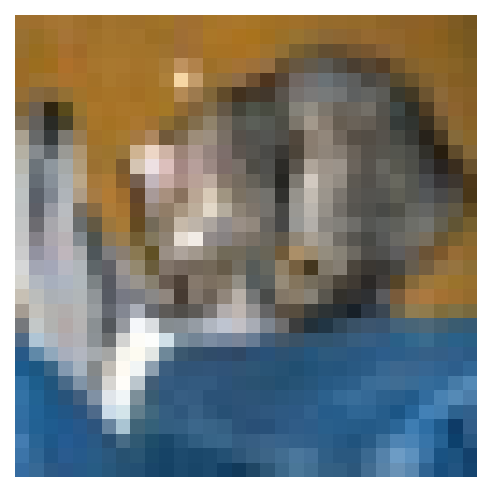

Ground Truth: cat             Predicted: cat            


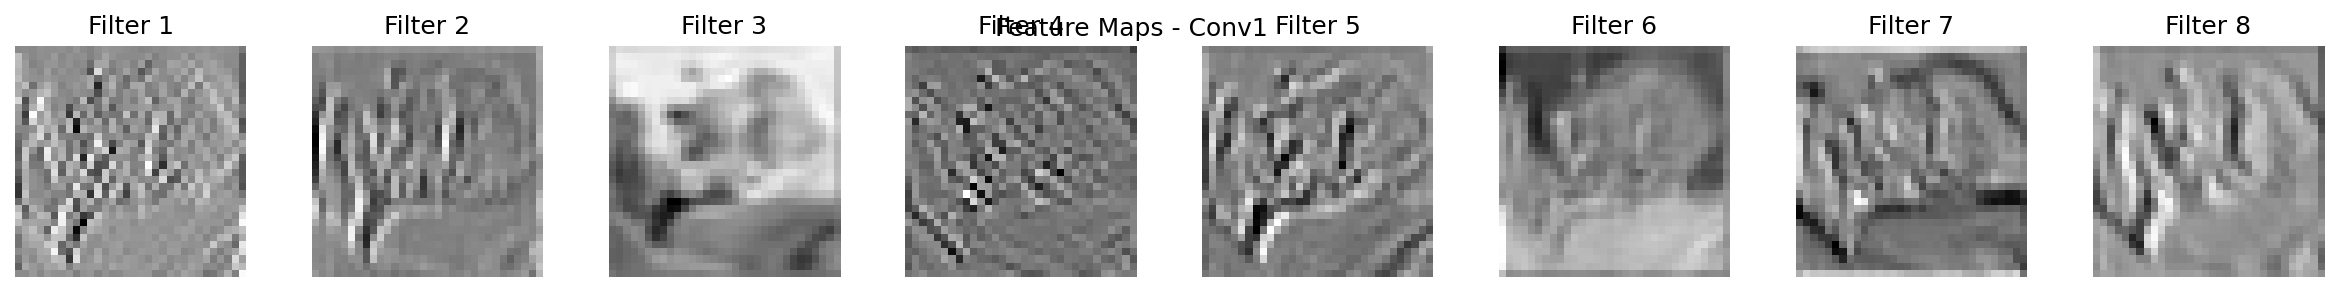

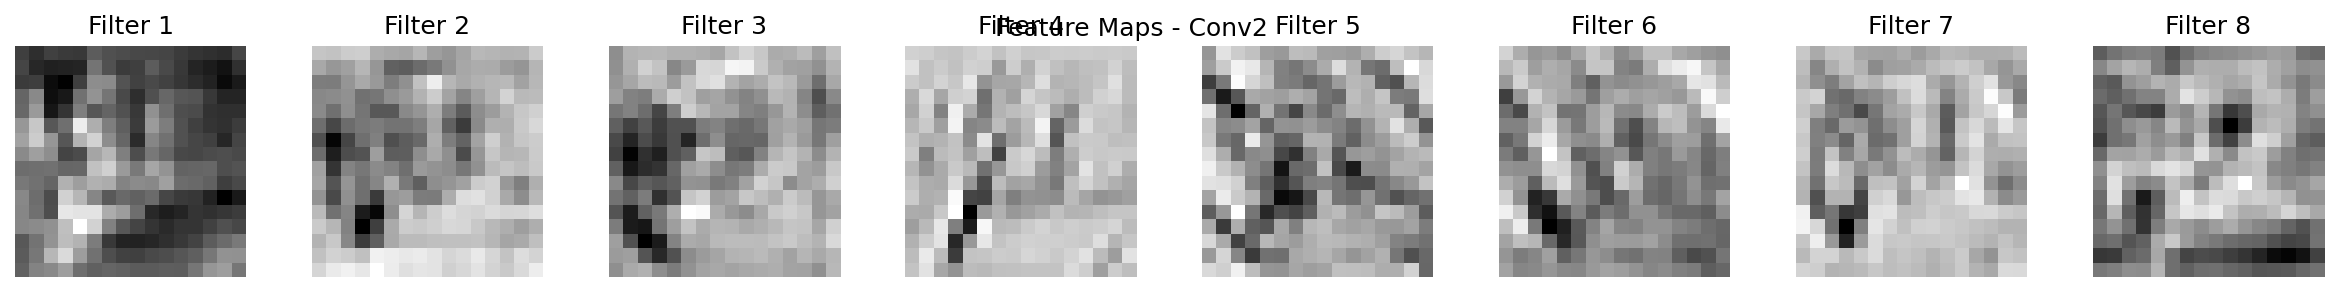

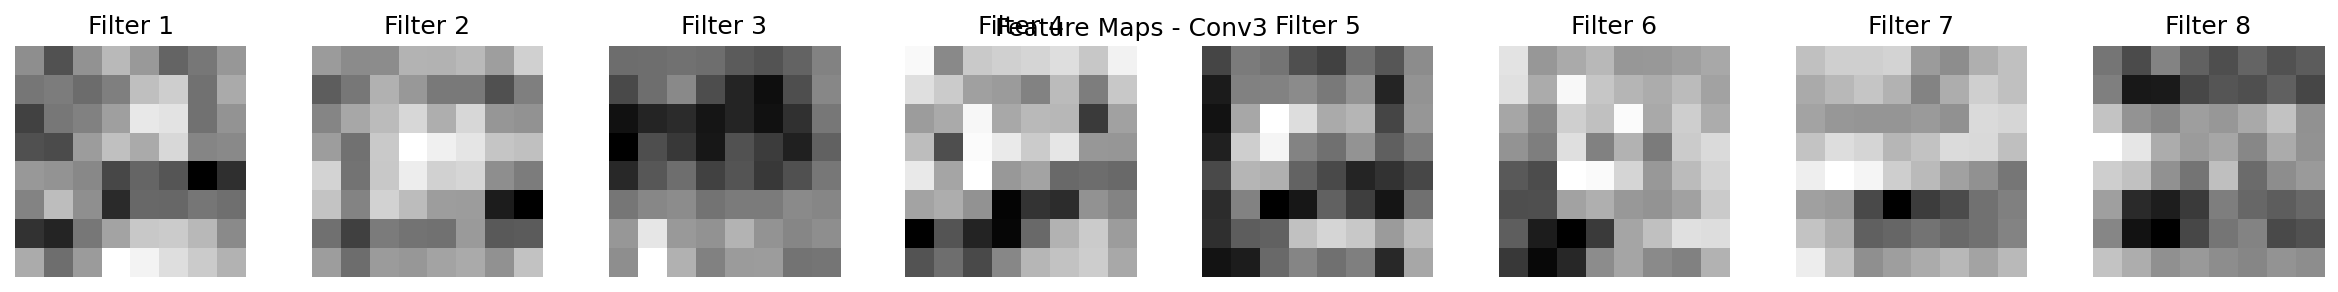

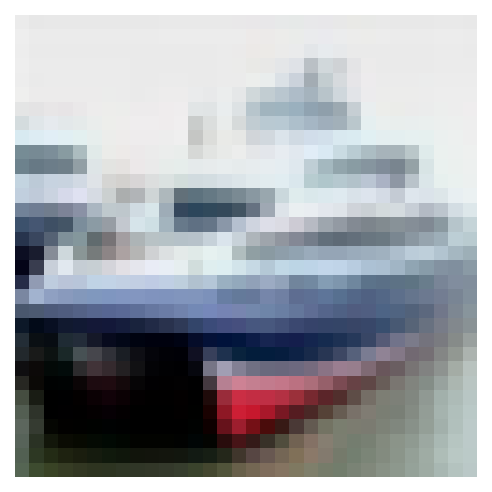

Ground Truth: ship            Predicted: ship           


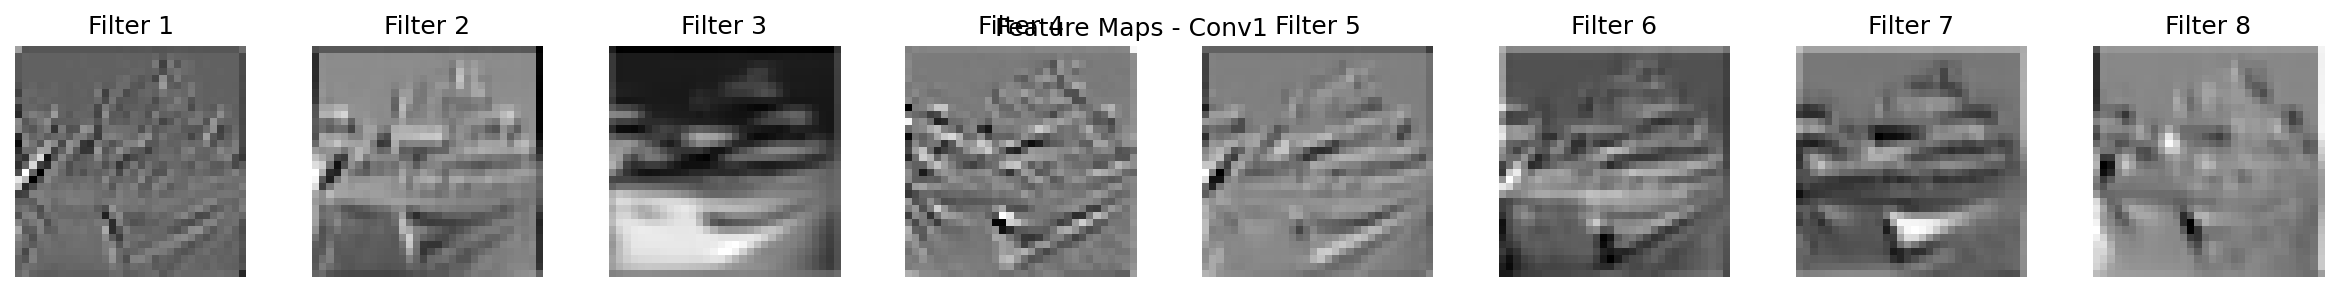

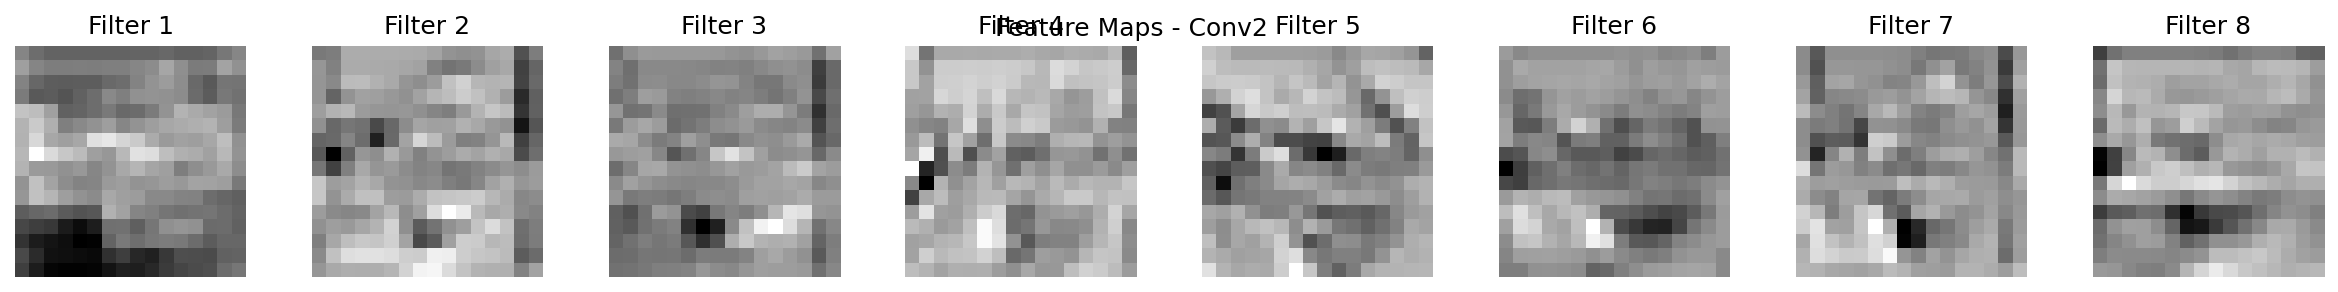

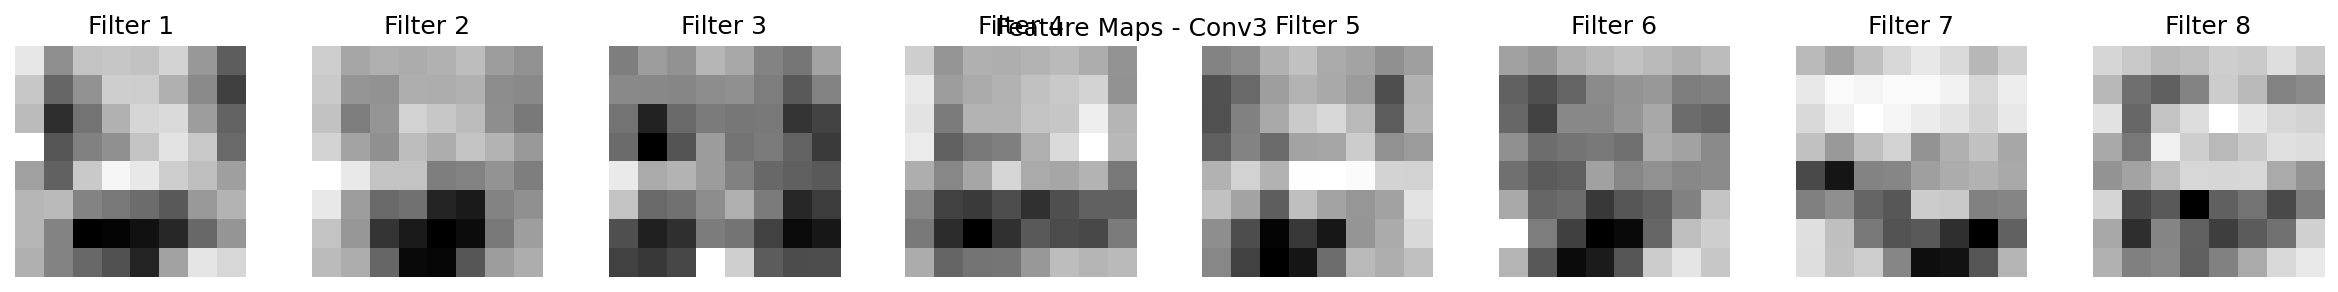


Prediksi Salah:


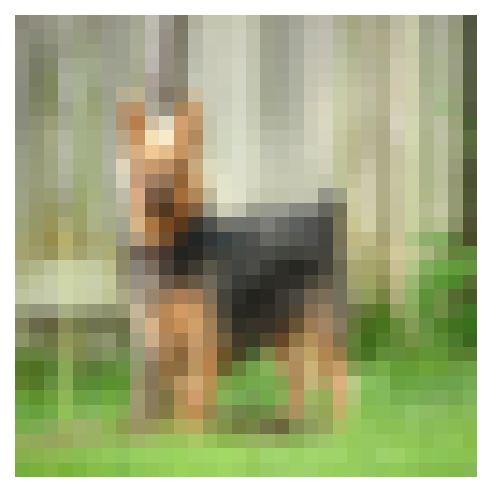

Ground Truth: dog             Predicted: deer           


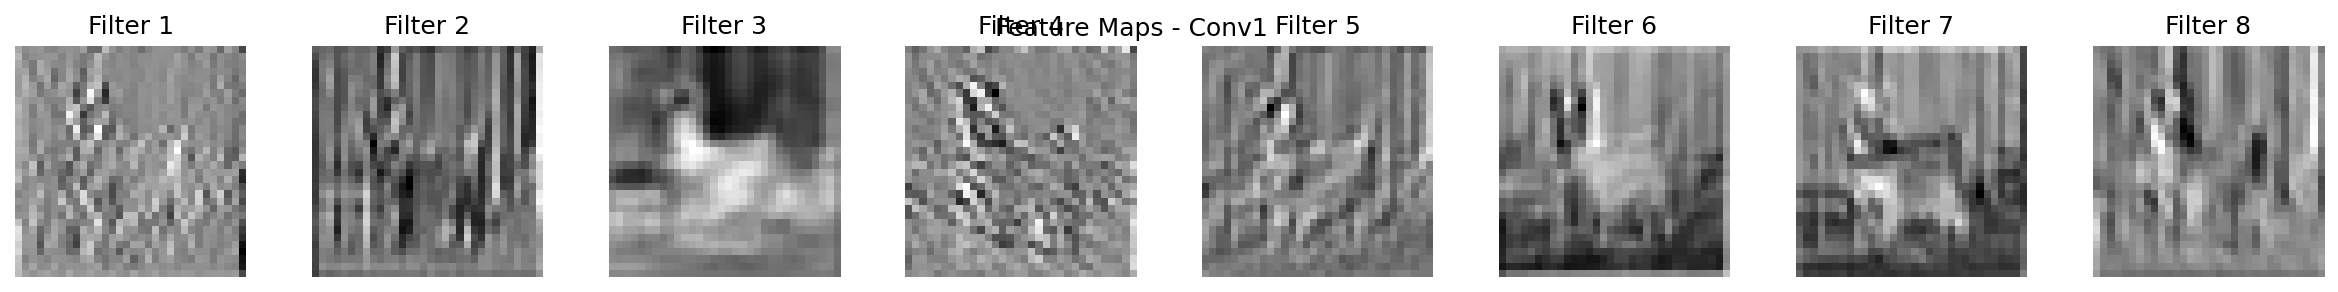

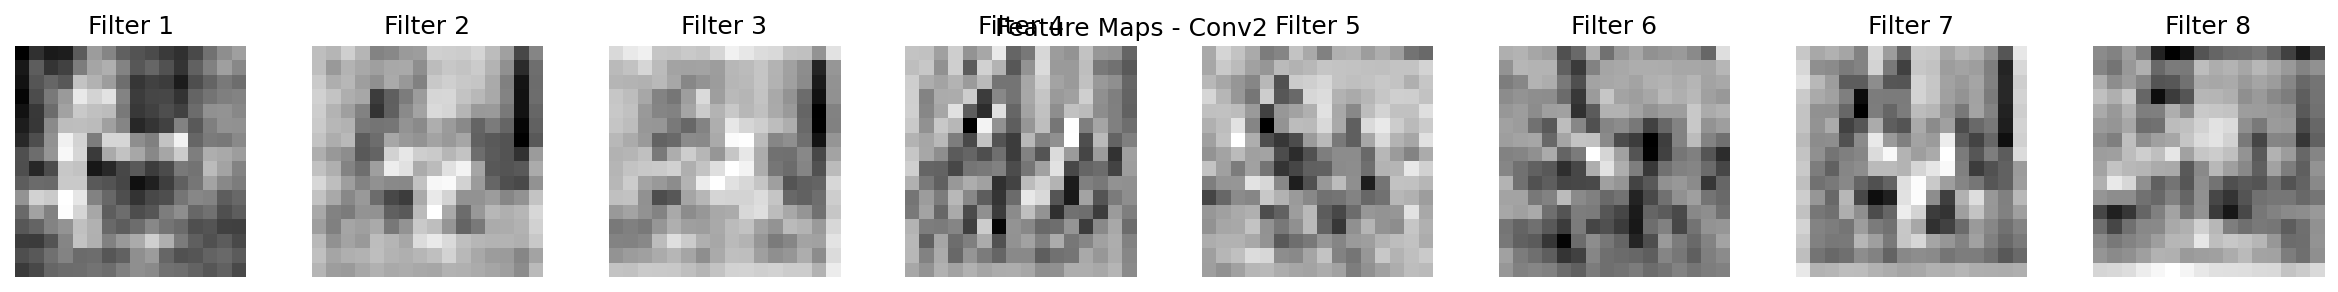

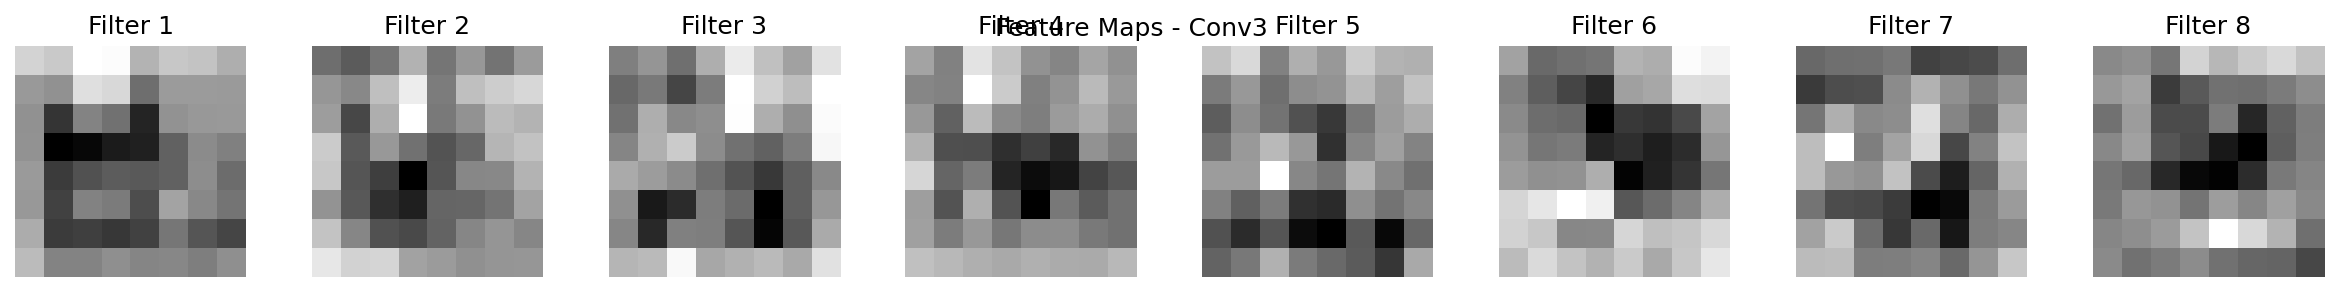

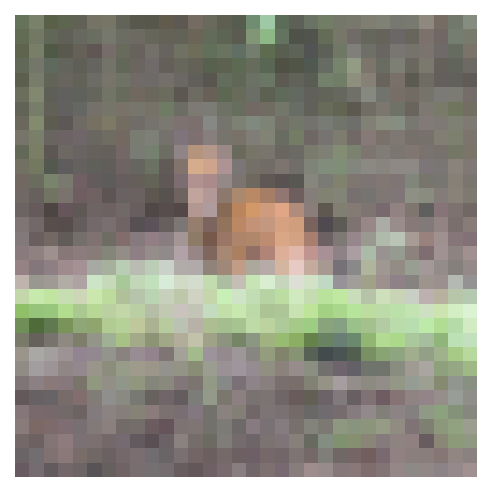

Ground Truth: deer            Predicted: bird           


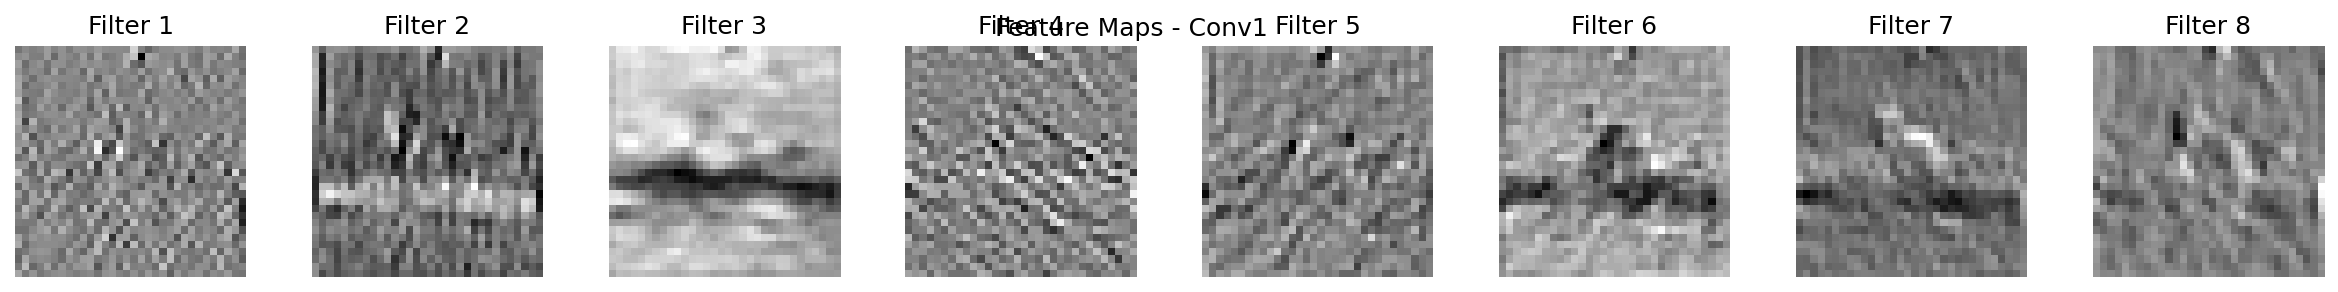

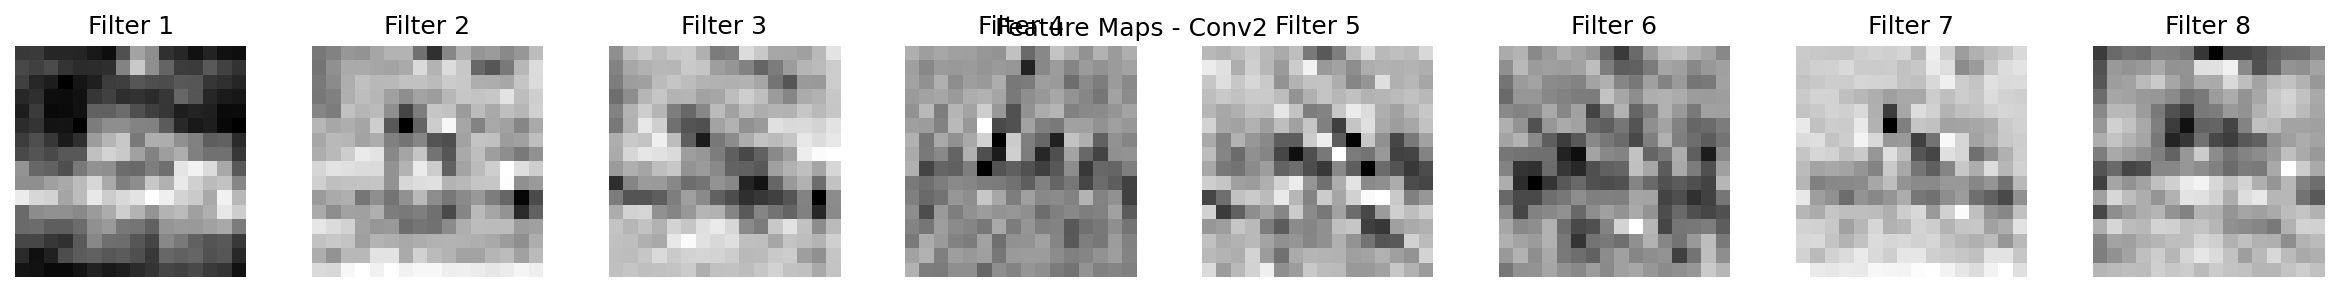

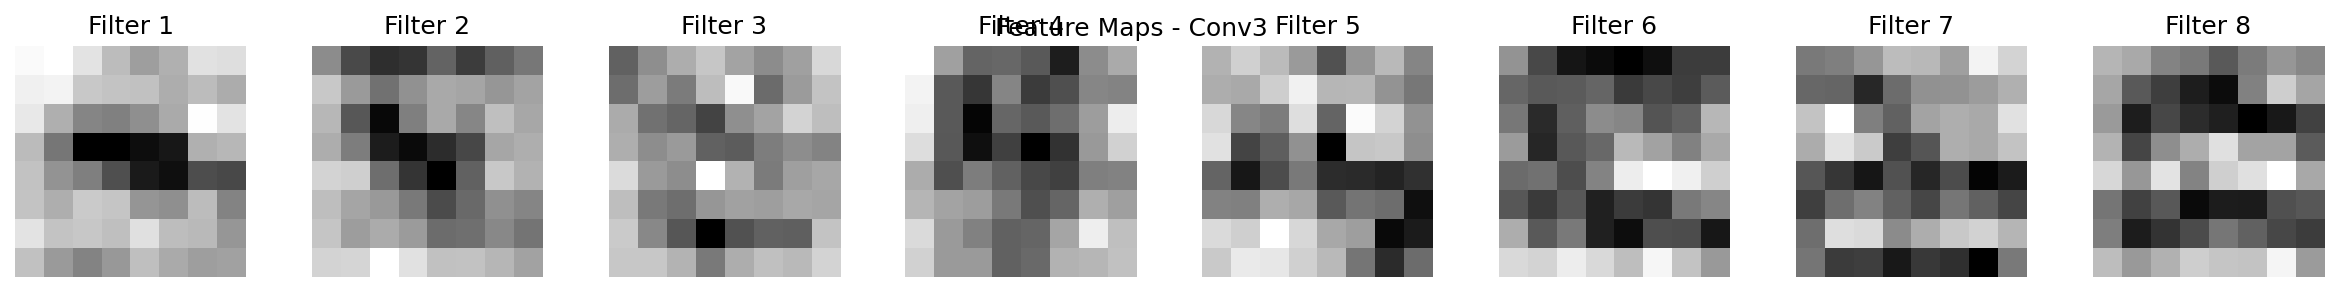

In [ ]:
# Tingkatkan DPI untuk visualisasi lebih tajam
plt.rcParams['figure.dpi'] = 150  # Mengatur DPI untuk resolusi lebih tinggi

# Fungsi untuk unnormalize dan menampilkan gambar
def imshow(img):  # Mendefinisikan fungsi untuk menampilkan gambar
    img = img / 2 + 0.5  # Unnormalize gambar dari [-1, 1] ke [0, 1]
    npimg = img.numpy()  # Konversi tensor ke array NumPy
    plt.figure(figsize=(4, 4))  # Ukuran plot yang lebih besar
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # Transpose untuk format RGB, interpolasi nearest
    plt.axis('off')  # Menyembunyikan sumbu
    plt.show()  # Menampilkan gambar

# Fungsi untuk menampilkan feature maps
def show_feature_maps(feature_maps, layer_name, num_filters=8):  # Mendefinisikan fungsi untuk menampilkan feature maps
    feature_maps = feature_maps.cpu().numpy()  # Konversi ke NumPy
    # Normalisasi feature maps
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min() + 1e-8)  # Normalisasi ke [0, 1]
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2))  # Membuat subplot untuk filter
    for i in range(min(num_filters, feature_maps.shape[1])):  # Iterasi filter
        axes[i].imshow(feature_maps[0, i], cmap='gray')  # Menampilkan feature map dengan colormap gray
        axes[i].axis('off')  # Menyembunyikan sumbu
        axes[i].set_title(f'Filter {i+1}')  # Menambahkan judul
    plt.suptitle(f'Feature Maps - {layer_name}')  # Judul utama
    plt.show()  # Menampilkan plot

# Hook untuk menangkap feature maps
feature_maps = {}  # Dictionary untuk menyimpan feature maps
def get_feature_maps(name):  # Fungsi untuk merekam feature maps
    def hook(model, input, output):  # Definisi hook
        feature_maps[name] = output.detach()  # Menyimpan output lapisan
    return hook  # Mengembalikan hook

# Set model ke mode evaluasi
best_model.eval()  # Mengatur model ke mode evaluasi

# Daftar kelas CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # Daftar nama kelas

# Membuat DataLoader dengan batch size terbaik
batch_size = best_params['batch_size']  # Mengambil batch size terbaik
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)  # Membuat DataLoader untuk test set

# Menambahkan hook ke lapisan konvolusi
best_model.conv1.register_forward_hook(get_feature_maps('conv1'))  # Hook untuk conv1
best_model.conv2.register_forward_hook(get_feature_maps('conv2'))  # Hook untuk conv2
best_model.conv3.register_forward_hook(get_feature_maps('conv3'))  # Hook untuk conv3

# Mengambil batch dari testloader
dataiter = iter(testloader)  # Membuat iterator untuk testloader
try:
    images, labels = next(dataiter)  # Mengambil batch pertama
except StopIteration:
    print("Test loader is empty.")  # Menangani testloader kosong
    images, labels = None, None  # Set images dan labels ke None

if images is not None:  # Memeriksa apakah batch tersedia
    images_to_device = images.to(device)  # Memindahkan gambar ke perangkat
    labels_to_device = labels.to(device)  # Memindahkan label ke perangkat
    with torch.no_grad():  # Menonaktifkan gradien untuk evaluasi
        outputs = best_model(images_to_device)  # Menghitung output model
        _, predicted = torch.max(outputs, 1)  # Mendapatkan prediksi kelas
    predicted = predicted.cpu()  # Memindahkan prediksi ke CPU
    labels = labels.cpu()  # Memindahkan label ke CPU

    # Memisahkan gambar yang diprediksi benar dan salah
    correct_idx = (predicted == labels).nonzero(as_tuple=True)[0]  # Indeks prediksi benar
    incorrect_idx = (predicted != labels).nonzero(as_tuple=True)[0]  # Indeks prediksi salah

    # Menampilkan gambar dan feature maps untuk prediksi benar (maksimal 2)
    if len(correct_idx) > 0:  # Memeriksa apakah ada prediksi benar
        print("\nPrediksi Benar:")  # Mencetak header
        for idx in correct_idx[:2]:  # Iterasi hingga 2 prediksi benar
            img = images[idx]  # Mengambil gambar
            imshow(img)  # Menampilkan gambar
            print(f'Ground Truth: {classes[labels[idx]]:<15s} Predicted: {classes[predicted[idx]]:<15s}')  # Mencetak label
            # Menampilkan feature maps untuk setiap lapisan
            with torch.no_grad():  # Menonaktifkan gradien
                _ = best_model(img.unsqueeze(0).to(device))  # Forward pass untuk satu gambar
            show_feature_maps(feature_maps['conv1'], 'Conv1', num_filters=8)  # Feature maps conv1
            show_feature_maps(feature_maps['conv2'], 'Conv2', num_filters=8)  # Feature maps conv2
            show_feature_maps(feature_maps['conv3'], 'Conv3', num_filters=8)  # Feature maps conv3

    # Menampilkan gambar dan feature maps untuk prediksi salah (maksimal 2)
    if len(incorrect_idx) > 0:  # Memeriksa apakah ada prediksi salah
        print("\nPrediksi Salah:")  # Mencetak header
        for idx in incorrect_idx[:2]:  # Iterasi hingga 2 prediksi salah
            img = images[idx]  # Mengambil gambar
            imshow(img)  # Menampilkan gambar
            print(f'Ground Truth: {classes[labels[idx]]:<15s} Predicted: {classes[predicted[idx]]:<15s}')  # Mencetak label
            # Menampilkan feature maps untuk setiap lapisan
            with torch.no_grad():  # Menonaktifkan gradien
                _ = best_model(img.unsqueeze(0).to(device))  # Forward pass untuk satu gambar
            show_feature_maps(feature_maps['conv1'], 'Conv1', num_filters=8)  # Feature maps conv1
            show_feature_maps(feature_maps['conv2'], 'Conv2', num_filters=8)  # Feature maps conv2
            show_feature_maps(feature_maps['conv3'], 'Conv3', num_filters=8)  # Feature maps conv3
else:
    print("Tidak ada data untuk divisualisasikan.")  # Menangani kasus tidak ada data

### **Contoh interpretasi Features Maps:**

 ##### **Ground Truth: cat | Predicted: cat**

Model berhasil mengklasifikasikan gambar **dengan benar** sebagai "cat", yang menunjukkan bahwa proses ekstraksi fitur bekerja efektif. Visualisasi ini menampilkan **aktivasi dari beberapa filter** di berbagai **layer convolutional**:

*   **Layer Conv1 (baris pertama)**
  * **Deteksi awal** terhadap pola dasar seperti **tepi (edges)**, **garis** dan **tekstur kasar**.
  * Aktivasi terlihat jelas dan padat, artinya model mampu menangkap fitur sederhana dari gambar input, seperti bentuk wajah atau garis tubuh kucing.
*    **Layer Conv2 (baris kedua)**:
  * Menampilkan fitur **yang lebih kompleks** dibanding Conv1.
  * Beberapa filter tampak memperkuat bagian spesifik dari gambar seperti **mata**, **telinga**, atau **kontur tubuh kucing**.
  * Aktivasi lebih beragam, menunjukkan proses abstraksi meningkat.



*   **Layer Conv3 (baris ketiga)**:
  * Aktivasi lebih **terkompresi dan abstrak**.
  * Di tahap ini, fitur yang diproses bukan lagi detail visual langsung, tetapi **representasi semantik** dari objek (ciri khas dari "kucing").
  * Model mulai menyaring informasi yang benar-benar penting untuk klasifikasi, mengabaikan noise.

**Kesimpulan:**

* Menunjukkan bahwa **CNN berhasil membangun hierarki fitur**, dari sederhana hingga kompleks.
* Aktivasi di tiap layer menunjukkan **respons kuat pada bagian-bagian penting gambar**, seperti bentuk wajah kucing atau pola bulu.
* Kombinasi aktivasi yang baik ini membantu model **mengenali objek secara akurat**, terbukti dari prediksi yang benar.





#####  **Ground Truth: dog | Predicted: deer**

Model **salah mengklasifikasikan** gambar anjing sebagai rusa. Visualisasi feature maps ini membantu kita memahami **mengapa kesalahan ini bisa terjadi**, dengan melihat aktivasi di berbagai layer.


*    **Layer Conv1 (baris pertama)**:
  * Menampilkan **deteksi awal** terhadap pola-pola dasar seperti garis dan tepi.
  * Bisa jadi bentuk tubuh anjing di gambar ini menyerupai rusa, terutama jika sedang berdiri atau dari sudut tertentu.
*   **Layer Conv2 (baris kedua)**
  * Aktivasi mulai berfokus pada **fitur bentuk dan tekstur yang lebih kompleks**, tapi terlihat **kurang spesifik**.
  * Filter 6 dan 7 memperlihatkan pola yang ambigu dan tidak jelas mencirikan bentuk khas anjing seperti wajah atau telinga.

*   **Layer Conv3 (baris ketiga)**

  * Aktivasi mulai **melemah dan membaur**, memperlihatkan bahwa representasi fitur menjadi **kurang informatif** untuk membedakan anjing dari rusa.
  * Banyak filter menghasilkan peta fitur yang tampak buram, yang bisa jadi menyebabkan **model kehilangan informasi kunci untuk klasifikasi yang benar**.
  * Ini bisa juga terjadi karena **pose anjing yang tidak umum** atau latar belakang yang mengganggu.

**Kesimpulan:**

* Model mengalami **kebingungan** karena ciri visual dari gambar anjing dalam kasus ini **mirip dengan rusa**, terutama dalam tekstur tubuh atau pose.
* Feature maps menunjukkan bahwa **aktivasi pada bagian penting (seperti wajah anjing)** tidak terlalu kuat, sehingga **model fokus pada fitur yang salah atau tidak khas**.
